In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *

In [16]:
G_21 = xr.open_dataset("../dataset/G_21_subset_imputed.nc")
G_21 = G_21.to_array().values.squeeze(0)
G_21.shape

(3565, 102484)

In [138]:
real_data_index = True
n = 1000
p = 10000
p_causal = 100
if real_data_index:
    np.random.seed(seed = None)
    p_max = G_21.shape[1]
    n_max = G_21.shape[0]
    SNP_index = np.random.choice(p_max,size = p, replace = False)
    subject_index =  np.random.choice(n_max,size = n, replace = False)
    G_21_sub = G_21[np.ix_(subject_index, SNP_index)]
    print(G_21_sub.shape)
    freq_snp = G_21_sub.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    G_21_sub = (G_21_sub-2*freq_snp)/sd_snp
    Xs = [G_21_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None

(1000, 10000)


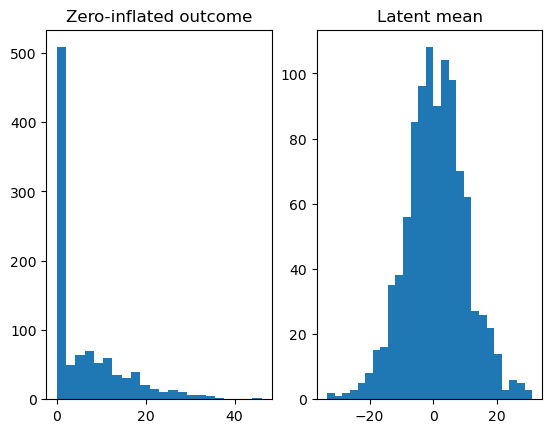

------------------------------------
genetic variance is 91.35928404453243
total variance is182.71856808906486
heritability is 0.5
------------------------------------


In [139]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.5
beta_bias = 1
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal, rho = rho, var = var, n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)

In [140]:
model = linear_slab_spike(p = p, init_pi_local = 0.1, init_pi_global = 0.1, init_beta_var = 2, init_noise_var = 1,
                         gumbel_softmax_temp = 0.3, gumbel_softmax_hard = False, 
                          a= 1.1,b=2.1, init_c= 1.1, init_d = 2.1,
                          q1 = 1.1, q2 = 1.1, init_q3 = 1.1, init_q4 = 1.1
                         ).double()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
for i in range(10000):
    loss = -model.ELBO(X.double(),y_star.double())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        lr_scheduler.step()
        print(f'At iteration {i}, the loss is {loss.item()}')

At iteration 0, the loss is 135496.52521407467
At iteration 1000, the loss is 8737.51239992195
At iteration 2000, the loss is 8336.80261029442
At iteration 3000, the loss is 8230.324550704008
At iteration 4000, the loss is 8182.525369161199
At iteration 5000, the loss is 8127.533747145009
At iteration 6000, the loss is 8111.618718598659
At iteration 7000, the loss is 8166.699318374819
At iteration 8000, the loss is 8108.8486620867225
At iteration 9000, the loss is 8085.722103328246


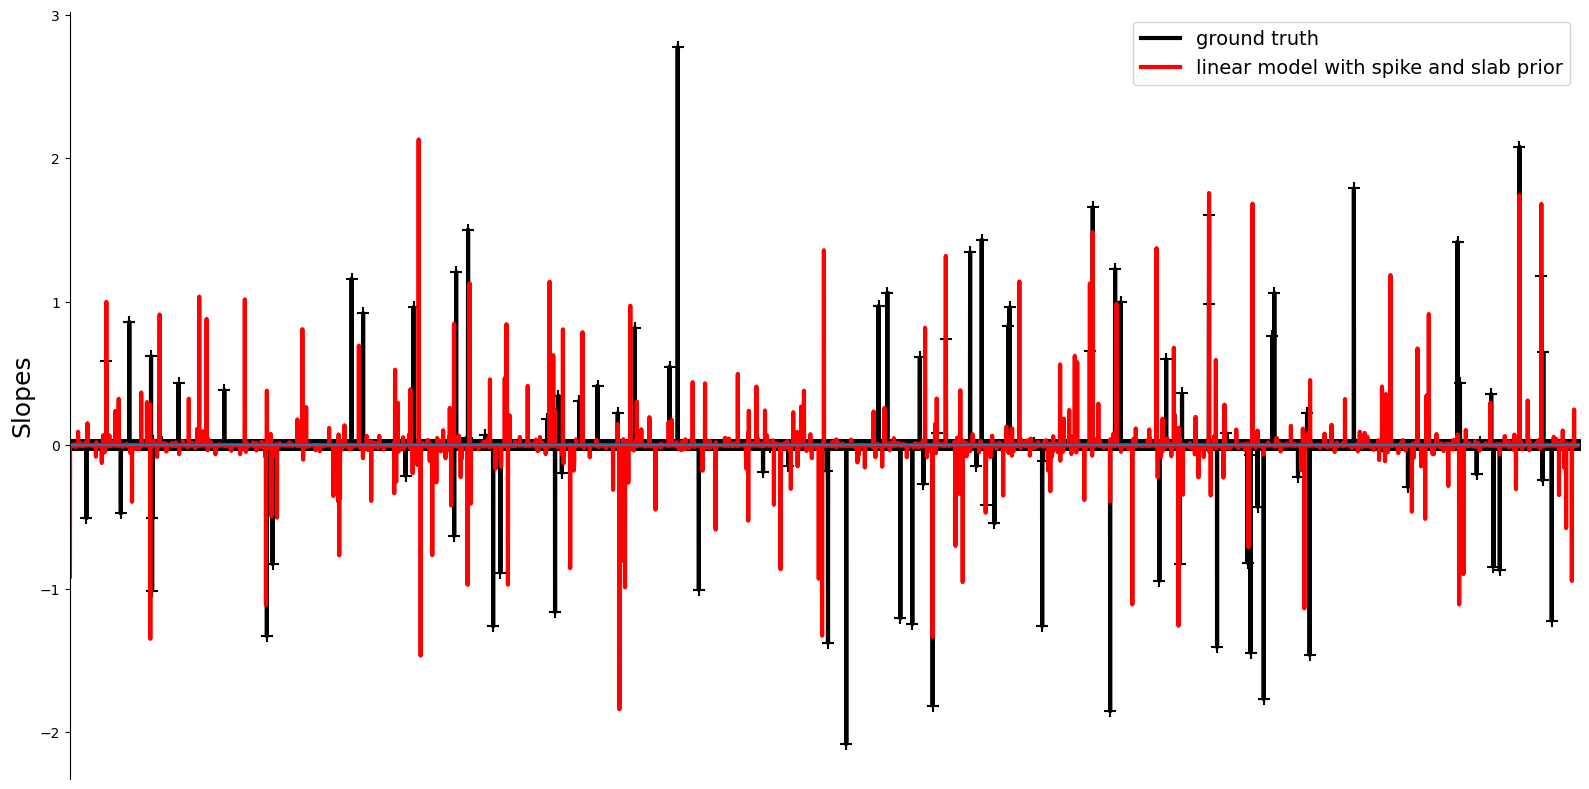

{'mean_h_est': 0.6865851553045308,
 'h_est_upper': 0.7274176328730034,
 'h_est_lower': 0.6418828433296888,
 'mean_var_genetic': 271.5415798112106,
 'noise_var': 123.06711004115375,
 'global_pi': 0.0287824208840065,
 'global_pi_upper': 0.032251402495411814,
 'global_pi_lower': 0.025534642428042514}

In [141]:
model.inference(X = X.double(), plot = True, true_beta = true_beta)

In [142]:
p_causal/p

0.01

In [108]:
torch.mean(torch.sigmoid(model.logit_pi_local))

tensor(0.0199, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [107]:
print(torch.max(torch.sigmoid(model.logit_pi_local)))
print(torch.min(torch.sigmoid(model.logit_pi_local)))

tensor(0.9605, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<MinBackward1>)


In [101]:
torch.exp(model.log_c)

tensor([200.7479], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [102]:
torch.exp(model.log_d)

tensor([9903.7246], dtype=torch.float64, grad_fn=<ExpBackward0>)

In [103]:
torch.min(model.beta_mu)

tensor(-3.7905, dtype=torch.float64, grad_fn=<MinBackward1>)

In [104]:
torch.max(model.beta_mu)

tensor(2.7154, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [105]:
torch.exp(model.beta_log_var)

tensor([1.6282, 1.6285, 1.6285,  ..., 1.6304, 1.6282, 1.6282],
       dtype=torch.float64, grad_fn=<ExpBackward0>)

In [106]:
torch.mean(torch.exp(model.beta_log_var))

tensor(1.6168, dtype=torch.float64, grad_fn=<MeanBackward0>)